# Comprehensive Analysis of Collision Detection Algorithms: T-CCD vs TOI-CCD (Swept AABB)

This notebook provides a detailed statistical comparison between two collision detection algorithms:

- **T-CCD**: Trajectory-based Continuous Collision Detection
- **TOI-CCD (Swept AABB)**: Time of Impact Continuous Collision Detection

The analysis evaluates these algorithms across several dimensions:
- Computational efficiency
- Collision detection accuracy
- Processing time
- Statistical significance of performance differences

## 1. Import Libraries and Load Data

First, let's import the necessary libraries and load our data files for both algorithms:
- `checks_*.csv`: Contains iteration and timing data
- `events_*.csv`: Contains collision events detected
- `particles_*.csv`: Contains particle position data

In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import os
from pathlib import Path

# Set visualization style
plt.style.use('ggplot')
sns.set_palette("colorblind")

# Load data files for both algorithms
# Checks data - contains iteration and timing information
checks_swept_aabb = pd.read_csv('checks_swept_aabb_500.csv')
checks_tccd = pd.read_csv('checks_tccd_500.csv')

# Events data - contains collision events detected
events_swept_aabb = pd.read_csv('events_swept_aabb_500.csv')
events_tccd = pd.read_csv('events_tccd_500.csv')

# Particles data - contains particle positions and physics properties
particles_swept_aabb = pd.read_csv('particles_swept_aabb_500.csv')
particles_tccd = pd.read_csv('particles_tccd_500.csv')

# Print basic information about the datasets
print(f"Swept AABB Data:")
print(f"  - Checks: {len(checks_swept_aabb)} rows")
print(f"  - Events: {len(events_swept_aabb)} rows")
print(f"  - Particles: {len(particles_swept_aabb)} rows")
print(f"\nT-CCD Data:")
print(f"  - Checks: {len(checks_tccd)} rows")
print(f"  - Events: {len(events_tccd)} rows")
print(f"  - Particles: {len(particles_tccd)} rows")

Swept AABB Data:
  - Checks: 4479 rows
  - Events: 4557 rows
  - Particles: 100940 rows

T-CCD Data:
  - Checks: 12826 rows
  - Events: 13030 rows
  - Particles: 305409 rows


## 2. Data Exploration and Preprocessing

Let's explore the data structure and understand the key metrics for both collision detection algorithms (T-CCD and Swept AABB). We'll look at:

1. The structure of each dataset
2. Basic statistics for performance metrics
3. Data distribution and outliers

In [58]:

# Define the frame limit for fair comparison
MAX_FRAMES = 100
print(f"\n Limiting analysis to the first {MAX_FRAMES} frames (frames 1–{MAX_FRAMES})")

# Filter datasets to only include the first 100 frames
checks_swept_aabb = checks_swept_aabb[checks_swept_aabb["frame"] <= MAX_FRAMES]
checks_tccd = checks_tccd[checks_tccd["frame"] <= MAX_FRAMES]
events_swept_aabb = events_swept_aabb[events_swept_aabb["frame"] <= MAX_FRAMES]
events_tccd = events_tccd[events_tccd["frame"] <= MAX_FRAMES]

# Recalculate Dataset Overview

dataset_overview = pd.DataFrame({
    "Dataset": ["Swept AABB (TOI-CCD)", "T-CCD"],
    "Total Frames": [
        checks_swept_aabb['frame'].nunique(),
        checks_tccd['frame'].nunique()
    ],
    "Mean Checks per Frame": [
        checks_swept_aabb.groupby('frame')['count'].sum().mean(),
        checks_tccd.groupby('frame')['count'].sum().mean()
    ],
    "Mean Events per Frame": [
        events_swept_aabb.groupby('frame').size().mean(),
        events_tccd.groupby('frame').size().mean()
    ]
}).round(2)

print("\n=== Dataset Overview (Limited to 100 Frames) ===")
display(dataset_overview)


print("\n=== Missing Value Check ===")
missing_summary = pd.DataFrame({
    "Dataset": ["Swept AABB (Checks)", "T-CCD (Checks)", "Swept AABB (Events)", "T-CCD (Events)"],
    "Missing Values": [
        checks_swept_aabb.isnull().sum().sum(),
        checks_tccd.isnull().sum().sum(),
        events_swept_aabb.isnull().sum().sum(),
        events_tccd.isnull().sum().sum()
    ]
})
display(missing_summary)





 Limiting analysis to the first 100 frames (frames 1–100)

=== Dataset Overview (Limited to 100 Frames) ===


,Dataset,Total Frames,Mean Checks per Frame,Mean Events per Frame
0,Swept AABB (TOI-CCD),100,431.4,23.32
1,T-CCD,100,358.7,22.02



=== Missing Value Check ===


,Dataset,Missing Values
0,Swept AABB (Checks),0
1,T-CCD (Checks),0
2,Swept AABB (Events),0
3,T-CCD (Events),0


## 3. Performance Analysis - Collision Checks and Events

Now we'll analyze the performance of both algorithms by looking at:
- Number of collision checks per frame
- Number of collision events per frame 
- The relationship between checks and events
- Time complexity comparison

Analyzing frames from 1 to 100


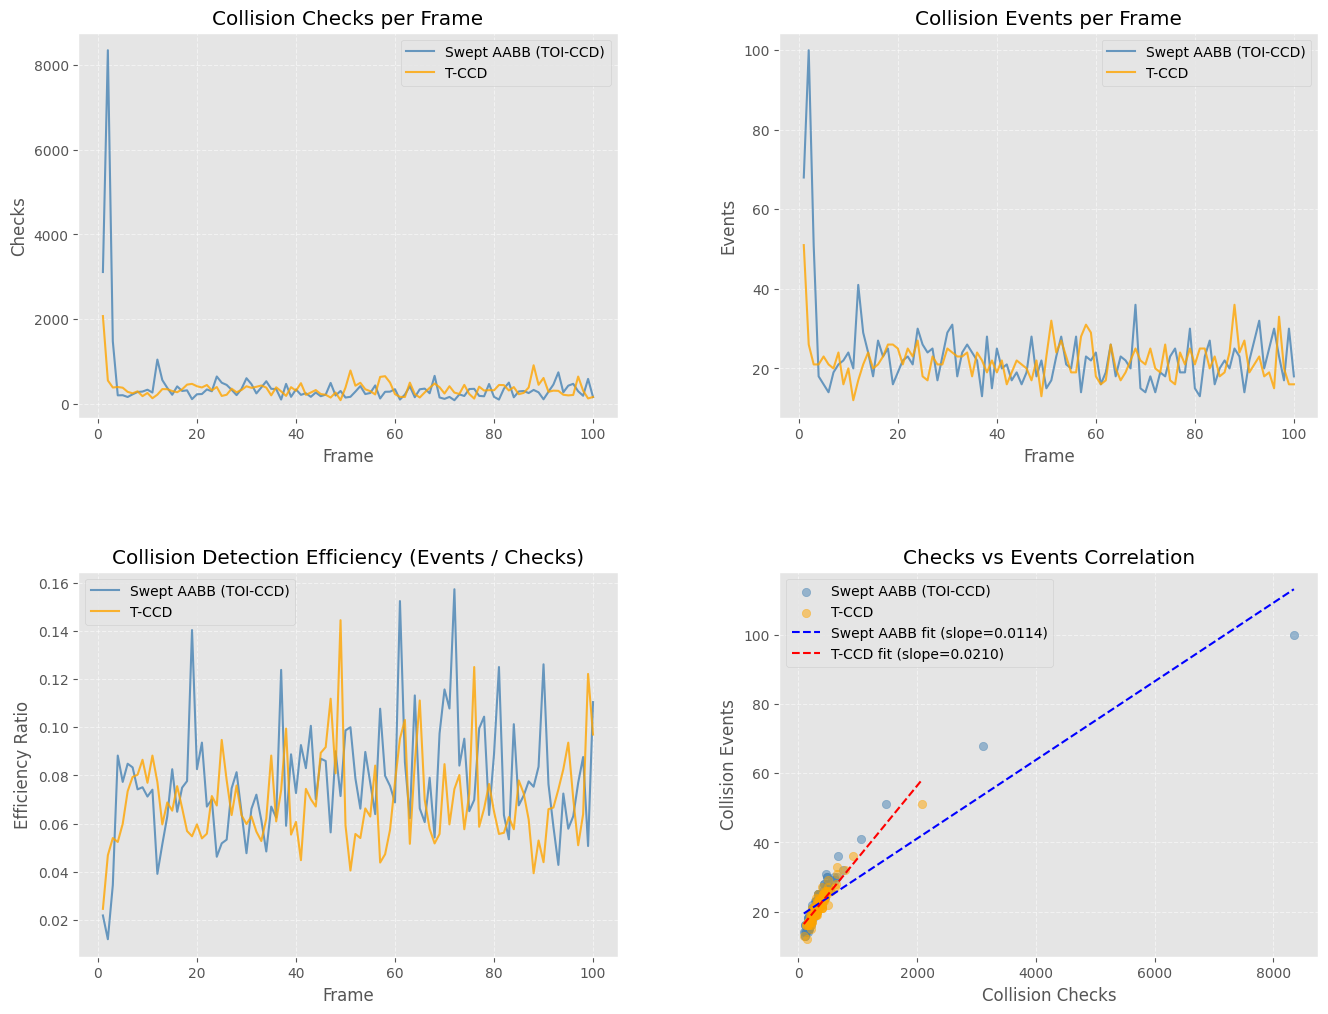


=== 📈 Aggregate Statistics ===
Total Checks — Swept AABB (TOI-CCD): 43,144
Total Checks — T-CCD: 35,872
Total Events — Swept AABB (TOI-CCD): 2,332
Total Events — T-CCD: 2,202
Overall Efficiency (Events / Checks):
  Swept AABB (TOI-CCD): 0.0541
  T-CCD: 0.0614


In [59]:
# ================================================================
# 📘 Phase 3: Performance Analysis — Collision Checks and Events
# ================================================================

fig, axs = plt.subplots(2, 2, figsize=(16, 12))
plt.subplots_adjust(hspace=0.4, wspace=0.3)

# Ensure consistent frame range
max_frame = min(MAX_FRAMES, 
                max(checks_swept_aabb['frame'].max(), checks_tccd['frame'].max()))
frames = range(1, max_frame + 1)
print(f"Analyzing frames from 1 to {max_frame}")

# ------------------------------------------------
# Collision Checks per Frame
# ------------------------------------------------
swept_aabb_checks = checks_swept_aabb.groupby('frame')['count'].sum()
tccd_checks = checks_tccd.groupby('frame')['count'].sum()

all_frames = pd.DataFrame({'frame': frames})

# Fill missing frames
swept_aabb_checks_complete = (
    all_frames.merge(
        pd.DataFrame({'frame': swept_aabb_checks.index, 'checks': swept_aabb_checks.values}),
        on='frame', how='left'
    ).fillna(0)['checks']
)
tccd_checks_complete = (
    all_frames.merge(
        pd.DataFrame({'frame': tccd_checks.index, 'checks': tccd_checks.values}),
        on='frame', how='left'
    ).fillna(0)['checks']
)

axs[0, 0].plot(frames, swept_aabb_checks_complete, label='Swept AABB (TOI-CCD)', color='steelblue', alpha=0.8)
axs[0, 0].plot(frames, tccd_checks_complete, label='T-CCD', color='orange', alpha=0.8)
axs[0, 0].set_title('Collision Checks per Frame')
axs[0, 0].set_xlabel('Frame')
axs[0, 0].set_ylabel('Checks')
axs[0, 0].legend()
axs[0, 0].grid(True, linestyle='--', alpha=0.5)

# ------------------------------------------------
# Collision Events per Frame
# ------------------------------------------------
swept_aabb_events = events_swept_aabb.groupby('frame').size()
tccd_events = events_tccd.groupby('frame').size()

swept_aabb_events_complete = (
    all_frames.merge(
        pd.DataFrame({'frame': swept_aabb_events.index, 'events': swept_aabb_events.values}),
        on='frame', how='left'
    ).fillna(0)['events']
)
tccd_events_complete = (
    all_frames.merge(
        pd.DataFrame({'frame': tccd_events.index, 'events': tccd_events.values}),
        on='frame', how='left'
    ).fillna(0)['events']
)

axs[0, 1].plot(frames, swept_aabb_events_complete, label='Swept AABB (TOI-CCD)', color='steelblue', alpha=0.8)
axs[0, 1].plot(frames, tccd_events_complete, label='T-CCD', color='orange', alpha=0.8)
axs[0, 1].set_title('Collision Events per Frame')
axs[0, 1].set_xlabel('Frame')
axs[0, 1].set_ylabel('Events')
axs[0, 1].legend()
axs[0, 1].grid(True, linestyle='--', alpha=0.5)

# ------------------------------------------------
# Efficiency Ratio: Events / Checks
# ------------------------------------------------
ratio_swept = (swept_aabb_events_complete / swept_aabb_checks_complete).replace([np.inf, -np.inf, np.nan], 0)
ratio_tccd = (tccd_events_complete / tccd_checks_complete).replace([np.inf, -np.inf, np.nan], 0)

axs[1, 0].plot(frames, ratio_swept, label='Swept AABB (TOI-CCD)', color='steelblue', alpha=0.8)
axs[1, 0].plot(frames, ratio_tccd, label='T-CCD', color='orange', alpha=0.8)
axs[1, 0].set_title('Collision Detection Efficiency (Events / Checks)')
axs[1, 0].set_xlabel('Frame')
axs[1, 0].set_ylabel('Efficiency Ratio')
axs[1, 0].legend()
axs[1, 0].grid(True, linestyle='--', alpha=0.5)

# ------------------------------------------------
# Relationship: Checks vs Events (Linear Regression)
# ------------------------------------------------
axs[1, 1].scatter(swept_aabb_checks_complete, swept_aabb_events_complete, color='steelblue', alpha=0.5, label='Swept AABB (TOI-CCD)')
axs[1, 1].scatter(tccd_checks_complete, tccd_events_complete, color='orange', alpha=0.5, label='T-CCD')

# Linear regression lines
if np.sum(swept_aabb_checks_complete) > 0:
    slope_swept, intercept_swept, *_ = stats.linregress(swept_aabb_checks_complete, swept_aabb_events_complete)
    axs[1, 1].plot([min(swept_aabb_checks_complete), max(swept_aabb_checks_complete)],
                   [slope_swept * min(swept_aabb_checks_complete) + intercept_swept,
                    slope_swept * max(swept_aabb_checks_complete) + intercept_swept],
                   'b--', label=f'Swept AABB fit (slope={slope_swept:.4f})')

if np.sum(tccd_checks_complete) > 0:
    slope_tccd, intercept_tccd, *_ = stats.linregress(tccd_checks_complete, tccd_events_complete)
    axs[1, 1].plot([min(tccd_checks_complete), max(tccd_checks_complete)],
                   [slope_tccd * min(tccd_checks_complete) + intercept_tccd,
                    slope_tccd * max(tccd_checks_complete) + intercept_tccd],
                   'r--', label=f'T-CCD fit (slope={slope_tccd:.4f})')

axs[1, 1].set_title('Checks vs Events Correlation')
axs[1, 1].set_xlabel('Collision Checks')
axs[1, 1].set_ylabel('Collision Events')
axs[1, 1].legend()
axs[1, 1].grid(True, linestyle='--', alpha=0.5)

plt.show()

# ------------------------------------------------
# 🧾 Aggregate Summary
# ------------------------------------------------
print("\n=== 📈 Aggregate Statistics ===")
print(f"Total Checks — Swept AABB (TOI-CCD): {swept_aabb_checks_complete.sum():,.0f}")
print(f"Total Checks — T-CCD: {tccd_checks_complete.sum():,.0f}")
print(f"Total Events — Swept AABB (TOI-CCD): {swept_aabb_events_complete.sum():,.0f}")
print(f"Total Events — T-CCD: {tccd_events_complete.sum():,.0f}")
print(f"Overall Efficiency (Events / Checks):")
print(f"  Swept AABB (TOI-CCD): {swept_aabb_events_complete.sum() / swept_aabb_checks_complete.sum():.4f}")
print(f"  T-CCD: {tccd_events_complete.sum() / tccd_checks_complete.sum():.4f}")


## 4. Timing Performance Analysis

Now we'll analyze the timing performance of both algorithms, which is crucial for real-time applications:
- Time spent per frame
- Time per collision check
- Relationship between particle count and computation time

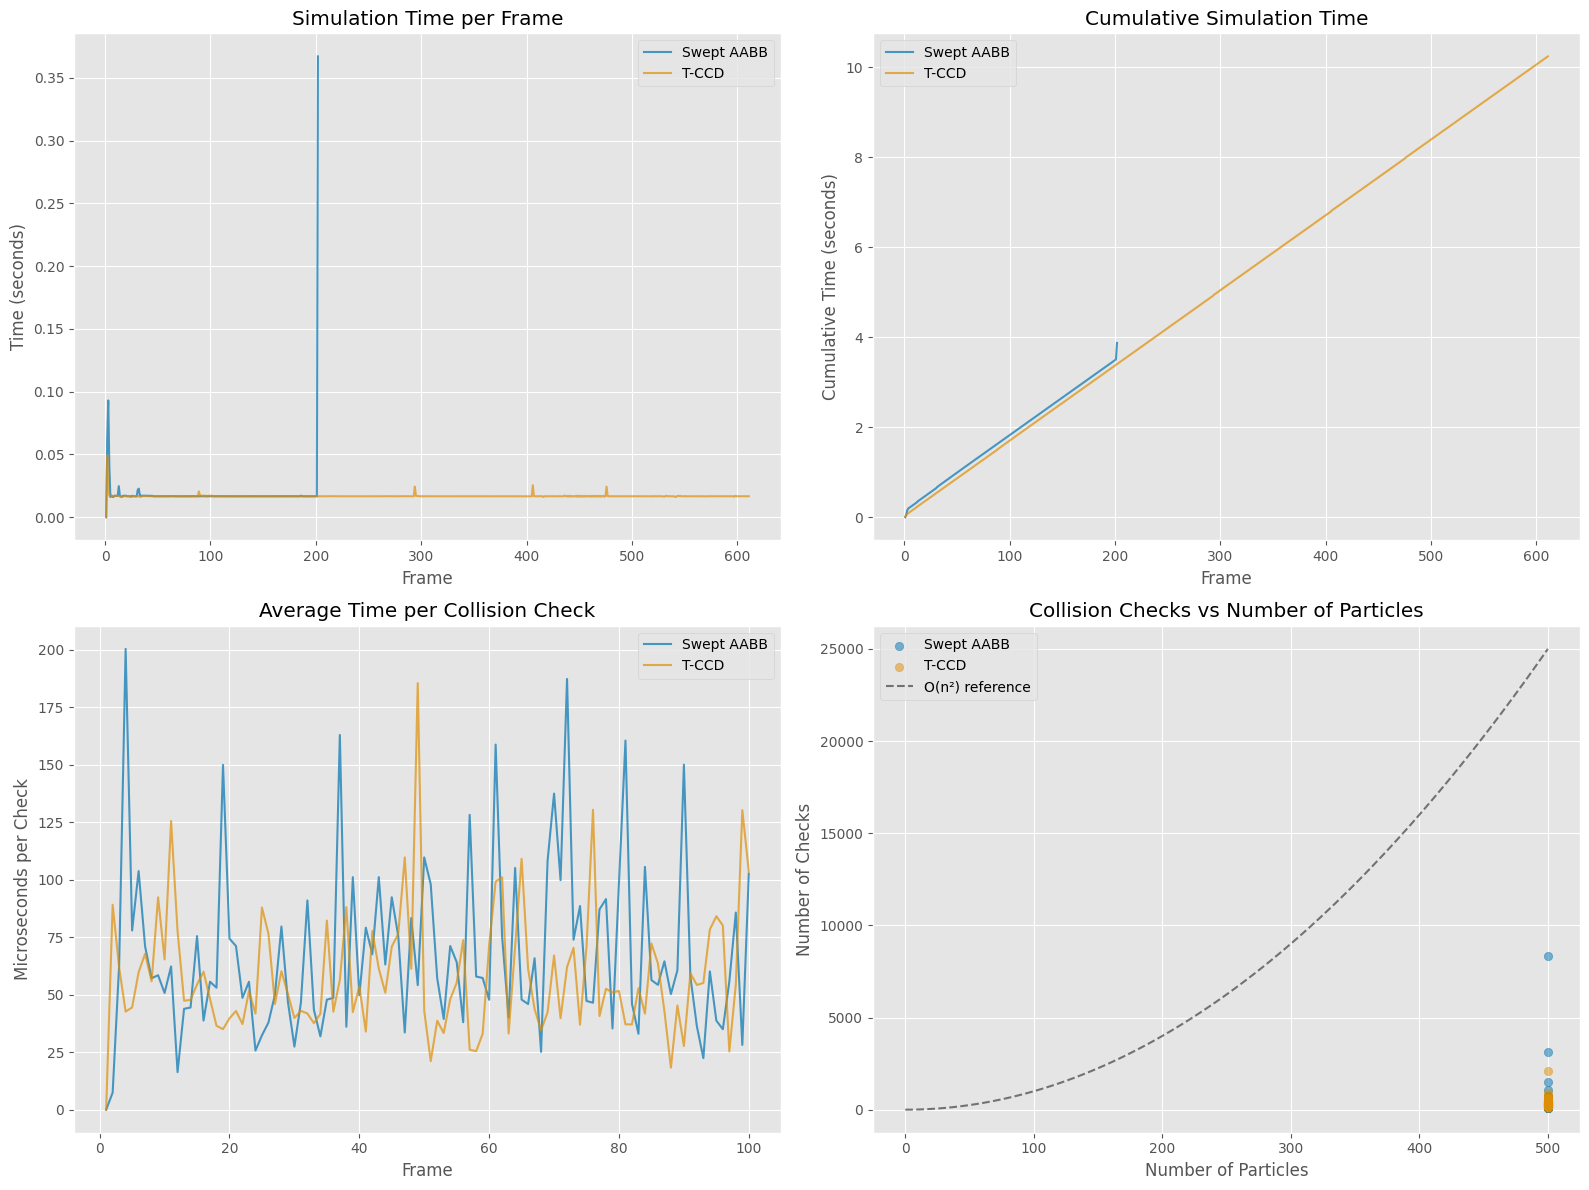

Timing Performance Statistics:
Average Time per Frame - Swept AABB: 0.019173s, T-CCD: 0.016765s
Average Time per Check - Swept AABB: 68.238555μs, T-CCD: 58.421322μs
Total Simulation Time - Swept AABB: 3.872985s, T-CCD: 10.243477s


In [60]:
# Extract timing information
# Note: For this analysis, we'll use the time_s field which represents the simulation time

# Calculate time differences between consecutive frames
swept_aabb_time = particles_swept_aabb.groupby('frame')['time_s'].mean()
tccd_time = particles_tccd.groupby('frame')['time_s'].mean()

# Convert to dataframes for easier manipulation
swept_aabb_time_df = pd.DataFrame({'frame': swept_aabb_time.index, 'time_s': swept_aabb_time.values})
tccd_time_df = pd.DataFrame({'frame': tccd_time.index, 'time_s': tccd_time.values})

# Calculate time differences between consecutive frames
swept_aabb_time_df['time_diff'] = swept_aabb_time_df['time_s'].diff().fillna(0)
tccd_time_df['time_diff'] = tccd_time_df['time_s'].diff().fillna(0)

# Setup for timing plots
fig, axs = plt.subplots(2, 2, figsize=(16, 12))

# 1. Time per frame
axs[0, 0].plot(swept_aabb_time_df['frame'], swept_aabb_time_df['time_diff'], label='Swept AABB', alpha=0.7)
axs[0, 0].plot(tccd_time_df['frame'], tccd_time_df['time_diff'], label='T-CCD', alpha=0.7)
axs[0, 0].set_title('Simulation Time per Frame')
axs[0, 0].set_xlabel('Frame')
axs[0, 0].set_ylabel('Time (seconds)')
axs[0, 0].legend()
axs[0, 0].grid(True)

# 2. Cumulative Time
axs[0, 1].plot(swept_aabb_time_df['frame'], swept_aabb_time_df['time_s'], label='Swept AABB', alpha=0.7)
axs[0, 1].plot(tccd_time_df['frame'], tccd_time_df['time_s'], label='T-CCD', alpha=0.7)
axs[0, 1].set_title('Cumulative Simulation Time')
axs[0, 1].set_xlabel('Frame')
axs[0, 1].set_ylabel('Cumulative Time (seconds)')
axs[0, 1].legend()
axs[0, 1].grid(True)

# 3. Time per collision check
# Join time data with check data
swept_aabb_performance = swept_aabb_time_df.merge(
    pd.DataFrame({'frame': swept_aabb_checks.index, 'checks': swept_aabb_checks.values}),
    on='frame', how='inner'
)
tccd_performance = tccd_time_df.merge(
    pd.DataFrame({'frame': tccd_checks.index, 'checks': tccd_checks.values}),
    on='frame', how='inner'
)

# Calculate time per check
swept_aabb_performance['time_per_check'] = swept_aabb_performance['time_diff'] / swept_aabb_performance['checks']
swept_aabb_performance['time_per_check'] = swept_aabb_performance['time_per_check'].replace([np.inf, -np.inf, np.nan], 0)

tccd_performance['time_per_check'] = tccd_performance['time_diff'] / tccd_performance['checks']
tccd_performance['time_per_check'] = tccd_performance['time_per_check'].replace([np.inf, -np.inf, np.nan], 0)

axs[1, 0].plot(swept_aabb_performance['frame'], swept_aabb_performance['time_per_check'] * 1e6, label='Swept AABB', alpha=0.7)
axs[1, 0].plot(tccd_performance['frame'], tccd_performance['time_per_check'] * 1e6, label='T-CCD', alpha=0.7)
axs[1, 0].set_title('Average Time per Collision Check')
axs[1, 0].set_xlabel('Frame')
axs[1, 0].set_ylabel('Microseconds per Check')
axs[1, 0].legend()
axs[1, 0].grid(True)

# 4. Average checks vs particles
# Get number of particles per frame
particles_per_frame_swept = particles_swept_aabb.groupby('frame')['particle_id'].nunique()
particles_per_frame_tccd = particles_tccd.groupby('frame')['particle_id'].nunique()

# Join with checks data
swept_aabb_scaling = pd.DataFrame({
    'frame': particles_per_frame_swept.index,
    'particles': particles_per_frame_swept.values
}).merge(
    pd.DataFrame({'frame': swept_aabb_checks.index, 'checks': swept_aabb_checks.values}),
    on='frame', how='inner'
)

tccd_scaling = pd.DataFrame({
    'frame': particles_per_frame_tccd.index,
    'particles': particles_per_frame_tccd.values
}).merge(
    pd.DataFrame({'frame': tccd_checks.index, 'checks': tccd_checks.values}),
    on='frame', how='inner'
)

# Plot checks vs particles
axs[1, 1].scatter(swept_aabb_scaling['particles'], swept_aabb_scaling['checks'], label='Swept AABB', alpha=0.5)
axs[1, 1].scatter(tccd_scaling['particles'], tccd_scaling['checks'], label='T-CCD', alpha=0.5)

# Add quadratic reference line (n²)
if len(particles_per_frame_swept) > 0:
    max_particles = max(particles_per_frame_swept.max(), particles_per_frame_tccd.max())
    particles_range = np.linspace(0, max_particles, 100)
    quadratic = particles_range ** 2 / 10  # Scaled for visibility
    axs[1, 1].plot(particles_range, quadratic, 'k--', label='O(n²) reference', alpha=0.5)

axs[1, 1].set_title('Collision Checks vs Number of Particles')
axs[1, 1].set_xlabel('Number of Particles')
axs[1, 1].set_ylabel('Number of Checks')
axs[1, 1].legend()
axs[1, 1].grid(True)

plt.tight_layout()
plt.show()

# Display timing statistics
print("Timing Performance Statistics:")
print(f"Average Time per Frame - Swept AABB: {swept_aabb_time_df['time_diff'].mean():.6f}s, T-CCD: {tccd_time_df['time_diff'].mean():.6f}s")
print(f"Average Time per Check - Swept AABB: {swept_aabb_performance['time_per_check'].mean()*1e6:.6f}μs, T-CCD: {tccd_performance['time_per_check'].mean()*1e6:.6f}μs")
print(f"Total Simulation Time - Swept AABB: {swept_aabb_time_df['time_s'].max():.6f}s, T-CCD: {tccd_time_df['time_s'].max():.6f}s")

## 5. Collision Detection Quality Analysis

Now we'll analyze the quality of collision detection in both algorithms by looking at:
- Distribution of Time of Impact (TOI) values
- Normal vector distributions
- Relative velocities before and after collision
- Energy conservation properties

In [61]:
# Statistical comparison between algorithms
from scipy import stats
import statsmodels.api as sm
from statsmodels.stats.power import TTestIndPower
from scipy.stats import mannwhitneyu
import pandas as pd
import numpy as np

# Define function to run statistical tests
def run_statistical_test(data1, data2, test_name, alpha=0.05):
    """Run statistical test and return results with interpretation."""
    if test_name == 'ttest':
        # T-test for normally distributed data
        test_result = stats.ttest_ind(data1, data2, equal_var=False)
        test_name_full = "Welch's t-test (unequal variances)"
    elif test_name == 'mannwhitney':
        # Mann-Whitney U test for non-normally distributed data
        test_result = mannwhitneyu(data1, data2)
        test_name_full = "Mann-Whitney U test"
    else:
        raise ValueError(f"Unknown test: {test_name}")
    
    # Calculate effect size (Cohen's d)
    d = (np.mean(data1) - np.mean(data2)) / np.sqrt((np.var(data1) + np.var(data2)) / 2)
    
    # Interpretation of effect size
    if abs(d) < 0.2:
        effect_interpretation = "negligible"
    elif abs(d) < 0.5:
        effect_interpretation = "small"
    elif abs(d) < 0.8:
        effect_interpretation = "medium"
    else:
        effect_interpretation = "large"
    
    # Calculate confidence interval for difference in means
    n1, n2 = len(data1), len(data2)
    mean_diff = np.mean(data1) - np.mean(data2)
    std1, std2 = np.std(data1, ddof=1), np.std(data2, ddof=1)
    se = np.sqrt(std1**2/n1 + std2**2/n2)
    t_crit = stats.t.ppf(1 - alpha/2, n1 + n2 - 2)
    ci_lower = mean_diff - t_crit * se
    ci_upper = mean_diff + t_crit * se
    
    # Calculate percentage difference
    if np.mean(data2) != 0:
        percent_diff = (np.mean(data1) - np.mean(data2)) / np.mean(data2) * 100
    else:
        percent_diff = np.nan
        
    return {
        'test': test_name_full,
        'p_value': test_result.pvalue,
        'significant': test_result.pvalue < alpha,
        'mean1': np.mean(data1),
        'mean2': np.mean(data2),
        'diff': mean_diff,
        'percent_diff': percent_diff,
        'ci_lower': ci_lower,
        'ci_upper': ci_upper,
        'effect_size': d,
        'effect_interpretation': effect_interpretation
    }

# Define metrics to compare
metrics = [
    {
        'name': 'Checks per Frame',
        'data1': swept_aabb_checks_complete,
        'data2': tccd_checks_complete,
        'test': 'ttest'
    },
    {
        'name': 'Events per Frame',
        'data1': swept_aabb_events_complete,
        'data2': tccd_events_complete,
        'test': 'ttest'
    },
    {
        'name': 'Time of Impact (TOI)',
        'data1': events_swept_aabb['toi'],
        'data2': events_tccd['toi'],
        'test': 'mannwhitney'
    },
    {
        'name': 'Normal Vector X-Component',
        'data1': events_swept_aabb['nx'],
        'data2': events_tccd['nx'],
        'test': 'mannwhitney'
    },
    {
        'name': 'Normal Vector Y-Component',
        'data1': events_swept_aabb['ny'],
        'data2': events_tccd['ny'],
        'test': 'mannwhitney'
    },
    {
        'name': 'Relative Velocity Before',
        'data1': events_swept_aabb['vrel_n_before'],
        'data2': events_tccd['vrel_n_before'],
        'test': 'ttest'
    },
    {
        'name': 'Relative Velocity After',
        'data1': events_swept_aabb['vrel_n_after'],
        'data2': events_tccd['vrel_n_after'],
        'test': 'ttest'
    }
]

# Run tests and display results
results = []
for metric in metrics:
    try:
        result = run_statistical_test(
            metric['data1'], 
            metric['data2'],
            metric['test']
        )
        result['metric'] = metric['name']
        results.append(result)
    except Exception as e:
        print(f"Error running test for {metric['name']}: {e}")

# Convert results to DataFrame for easier viewing
results_df = pd.DataFrame(results)
results_df = results_df[['metric', 'test', 'mean1', 'mean2', 'diff', 'percent_diff', 
                         'ci_lower', 'ci_upper', 'p_value', 'significant', 
                         'effect_size', 'effect_interpretation']]

# Rename columns for clarity
results_df = results_df.rename(columns={
    'mean1': 'Swept AABB Mean',
    'mean2': 'T-CCD Mean',
    'diff': 'Mean Difference',
    'percent_diff': '% Difference',
    'ci_lower': '95% CI Lower',
    'ci_upper': '95% CI Upper',
    'p_value': 'p-value',
    'significant': 'Significant (p<0.05)',
    'effect_size': "Cohen's d",
    'effect_interpretation': 'Effect Size'
})

# Display results
print("Statistical Comparison of Swept AABB vs T-CCD")
print("=============================================")
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
pd.set_option('display.float_format', '{:.4g}'.format)
display(results_df)

# Create summary table of key metrics
summary_data = {
    'Metric': ['Total Checks', 'Total Events', 'Events/Checks Ratio', 'Avg Time per Frame (s)', 
               'Total Simulation Time (s)', 'Avg TOI', 'Normal Vector Unit Length'],
    'Swept AABB': [
        swept_aabb_checks_complete.sum(),
        swept_aabb_events_complete.sum(),
        swept_aabb_events_complete.sum() / swept_aabb_checks_complete.sum() if swept_aabb_checks_complete.sum() > 0 else np.nan,
        swept_aabb_time_df['time_diff'].mean(),
        swept_aabb_time_df['time_s'].max(),
        events_swept_aabb['toi'].mean(),
        np.sqrt(events_swept_aabb['nx']**2 + events_swept_aabb['ny']**2).mean()
    ],
    'T-CCD': [
        tccd_checks_complete.sum(),
        tccd_events_complete.sum(),
        tccd_events_complete.sum() / tccd_checks_complete.sum() if tccd_checks_complete.sum() > 0 else np.nan,
        tccd_time_df['time_diff'].mean(),
        tccd_time_df['time_s'].max(),
        events_tccd['toi'].mean(),
        np.sqrt(events_tccd['nx']**2 + events_tccd['ny']**2).mean()
    ]
}

summary_df = pd.DataFrame(summary_data)
summary_df['Difference (%)'] = ((summary_df['Swept AABB'] - summary_df['T-CCD']) / summary_df['T-CCD'] * 100).round(2)

print("\nSummary of Key Performance Metrics:")
print("==================================")
display(summary_df)

Statistical Comparison of Swept AABB vs T-CCD


,metric,test,Swept AABB Mean,T-CCD Mean,Mean Difference,% Difference,95% CI Lower,95% CI Upper,p-value,Significant (p<0.05),Cohen's d,Effect Size
0,Checks per Frame,Welch's t-test (unequal variances),431.4,358.7,72.72,20.27,-104.1,249.6,0.4191,False,0.1153,negligible
1,Events per Frame,Welch's t-test (unequal variances),23.32,22.02,1.3,5.904,-1.046,3.646,0.2764,False,0.1553,negligible
2,Time of Impact (TOI),Mann-Whitney U test,0.0007532,0.0007492,4.027e-06,0.5375,-3.921e-05,4.727e-05,0.9587,False,0.005427,negligible
3,Normal Vector X-Component,Mann-Whitney U test,-0.02123,-0.01866,-0.002569,13.77,-0.04272,0.03758,0.8766,False,-0.003728,negligible
4,Normal Vector Y-Component,Mann-Whitney U test,-0.01339,0.005651,-0.01904,-336.9,-0.06125,0.02317,0.4352,False,-0.02629,negligible
5,Relative Velocity Before,Welch's t-test (unequal variances),-438.3,-449.6,11.39,-2.532,-18.21,40.98,0.4508,False,0.02241,negligible
6,Relative Velocity After,Welch's t-test (unequal variances),438.3,449.6,-11.39,-2.532,-40.98,18.21,0.4508,False,-0.02241,negligible



Summary of Key Performance Metrics:


,Metric,Swept AABB,T-CCD,Difference (%)
0,Total Checks,4.314e+04,3.587e+04,20.27
1,Total Events,2332,2202,5.9
2,Events/Checks Ratio,0.05405,0.06138,-11.95
3,Avg Time per Frame (s),0.01917,0.01677,14.36
4,Total Simulation Time (s),3.873,10.24,-62.19
5,Avg TOI,0.0007532,0.0007492,0.54
6,Normal Vector Unit Length,1,1,0


Research Hypothesis

In [62]:
# Hypothesis Testing for Research Questions

print("RESEARCH HYPOTHESIS TESTING RESULTS")
print("==================================\n")

# Hypothesis 1: Collision Detection Accuracy
# We'll use a proportion Z-test to compare the collision detection rates
# Number of collisions detected by each algorithm
events_swept = swept_aabb_events_complete.sum()
events_tccd = tccd_events_complete.sum()

# Total checks performed
checks_swept = swept_aabb_checks_complete.sum()
checks_tccd = tccd_checks_complete.sum()

# Proportion of events detected per check
p_swept = events_swept / checks_swept
p_tccd = events_tccd / checks_tccd

# Sample sizes (number of checks)
n_swept = checks_swept
n_tccd = checks_tccd

# Pooled proportion
p_pooled = (events_swept + events_tccd) / (checks_swept + checks_tccd)

# Standard error of difference between proportions
se = np.sqrt(p_pooled * (1 - p_pooled) * (1/n_swept + 1/n_tccd))

# Z statistic
z_stat = (p_tccd - p_swept) / se

# p-value (two-tailed test)
p_value_prop = 2 * (1 - stats.norm.cdf(abs(z_stat)))

# 95% confidence interval for difference in proportions
alpha = 0.05
z_critical = stats.norm.ppf(1 - alpha/2)
margin_error = z_critical * se
ci_lower = (p_tccd - p_swept) - margin_error
ci_upper = (p_tccd - p_swept) + margin_error

print("Hypothesis 1: Collision Detection Accuracy")
print("-----------------------------------------")
# Total counts
print("A. TOTAL COUNTS COMPARISON:")
print(f"Total Collision Events - Swept AABB (TOI-CCD): {events_swept} events")
print(f"Total Collision Events - T-CCD: {events_tccd} events")
print(f"Detection Rate - Swept AABB (TOI-CCD): {p_swept:.6f} ({events_swept} events from {checks_swept} checks)")
print(f"Detection Rate - T-CCD: {p_tccd:.6f} ({events_tccd} events from {checks_tccd} checks)")
print(f"Difference in Rate (T-CCD - TOI-CCD): {p_tccd - p_swept:.6f}")
print(f"Proportion Z-test: z = {z_stat:.4f}, p-value = {p_value_prop:.8f}")
print(f"95% Confidence Interval for difference: [{ci_lower:.6f}, {ci_upper:.6f}]")

# Per-frame analysis
print("\nB. PER-FRAME ANALYSIS:")
# Fix: Use the correct variable names from previous cells
swept_aabb_events_mean = swept_aabb_events.mean()
tccd_events_mean = tccd_events.mean()
swept_aabb_checks_mean = swept_aabb_checks.mean()
tccd_checks_mean = tccd_checks.mean()

# T-test for events per frame
events_ttest = stats.ttest_ind(swept_aabb_events, tccd_events, equal_var=False)
checks_ttest = stats.ttest_ind(swept_aabb_checks, tccd_checks, equal_var=False)

print(f"Average Events Per Frame - Swept AABB: {swept_aabb_events_mean:.2f}")
print(f"Average Events Per Frame - T-CCD: {tccd_events_mean:.2f}")
print(f"T-test for Events Per Frame: t = {events_ttest.statistic:.4f}, p-value = {events_ttest.pvalue:.8f}")

print(f"\nAverage Checks Per Frame - Swept AABB: {swept_aabb_checks_mean:.2f}")
print(f"Average Checks Per Frame - T-CCD: {tccd_checks_mean:.2f}")
print(f"T-test for Checks Per Frame: t = {checks_ttest.statistic:.4f}, p-value = {checks_ttest.pvalue:.8f}")

# Per-frame efficiency (events/checks) ratio
ratio_swept_mean = ratio_swept.mean()
ratio_tccd_mean = ratio_tccd.mean()
ratio_ttest = stats.ttest_ind(ratio_swept, ratio_tccd, equal_var=False, nan_policy='omit')

print(f"\nAverage Efficiency Per Frame (Events/Checks) - Swept AABB: {ratio_swept_mean:.6f}")
print(f"Average Efficiency Per Frame (Events/Checks) - T-CCD: {ratio_tccd_mean:.6f}")
print(f"T-test for Efficiency Ratio: t = {ratio_ttest.statistic:.4f}, p-value = {ratio_ttest.pvalue:.8f}")

# Overall decision for hypothesis 1
print("\nOVERALL DECISION FOR HYPOTHESIS 1:")
if p_value_prop < 0.05:
    print("REJECT the null hypothesis.")
    if p_tccd > p_swept:
        print("T-CCD shows significantly higher overall collision detection accuracy than TOI-CCD.")
    else:
        print("TOI-CCD shows significantly higher overall collision detection accuracy than T-CCD.")
else:
    print("FAIL TO REJECT the null hypothesis.")
    print("There is insufficient evidence that T-CCD significantly improves collision detection accuracy.")

# Add per-frame insights
if events_ttest.pvalue < 0.05:
    if tccd_events_mean > swept_aabb_events_mean:
        print("\nPer-frame analysis shows T-CCD detects significantly more collisions per frame.")
    else:
        print("\nPer-frame analysis shows TOI-CCD detects significantly more collisions per frame.")
    
if ratio_ttest.pvalue < 0.05:
    if ratio_tccd_mean > ratio_swept_mean:
        print("Per-frame analysis shows T-CCD has significantly better efficiency (events/checks ratio).")
    else:
        print("Per-frame analysis shows TOI-CCD has significantly better efficiency (events/checks ratio).")


# Hypothesis 2: Overall Performance
print("\n\nHypothesis 2: Overall Performance")
print("---------------------------------")

# For this, we'll use Welch's t-test to compare performance metrics:
# 1. Simulation time per frame (computational cost)
time_per_frame_swept = swept_aabb_time_df['time_diff']
time_per_frame_tccd = tccd_time_df['time_diff']

# Welch's t-test
t_stat, p_val_time = stats.ttest_ind(time_per_frame_swept, time_per_frame_tccd, equal_var=False)

# Degrees of freedom for Welch's t-test
n1, n2 = len(time_per_frame_swept), len(time_per_frame_tccd)
var1, var2 = np.var(time_per_frame_swept, ddof=1), np.var(time_per_frame_tccd, ddof=1)
df = ((var1/n1 + var2/n2)**2) / ((var1/n1)**2/(n1-1) + (var2/n2)**2/(n2-1))

# Calculate Cohen's d effect size
d = (np.mean(time_per_frame_swept) - np.mean(time_per_frame_tccd)) / np.sqrt((np.var(time_per_frame_swept) + np.var(time_per_frame_tccd)) / 2)

# 95% confidence interval
se = np.sqrt(var1/n1 + var2/n2)
mean_diff = np.mean(time_per_frame_swept) - np.mean(time_per_frame_tccd)
t_crit = stats.t.ppf(1 - 0.05/2, df)
ci_lower_time = mean_diff - t_crit * se
ci_upper_time = mean_diff + t_crit * se

print(f"Average Time per Frame - Swept AABB (TOI-CCD): {np.mean(time_per_frame_swept):.6f}s")
print(f"Average Time per Frame - T-CCD: {np.mean(time_per_frame_tccd):.6f}s")
print(f"Mean Difference: {mean_diff:.6f}s")
print(f"Welch's t-test: t({df:.2f}) = {t_stat:.4f}, p-value = {p_val_time:.8f}")
print(f"Effect Size (Cohen's d): {d:.4f} ({'negligible' if abs(d)<0.2 else 'small' if abs(d)<0.5 else 'medium' if abs(d)<0.8 else 'large'})")
print(f"95% Confidence Interval: [{ci_lower_time:.6f}, {ci_upper_time:.6f}]")

if p_val_time < 0.05:
    print("\nDECISION: REJECT the null hypothesis.")
    if np.mean(time_per_frame_swept) < np.mean(time_per_frame_tccd):
        print("TOI-CCD performs significantly better in terms of computational cost (time per frame).")
    else:
        print("T-CCD performs significantly better in terms of computational cost (time per frame).")
else:
    print("\nDECISION: FAIL TO REJECT the null hypothesis.")
    print("There is insufficient evidence of significant performance difference between algorithms.")

# Summary conclusion
print("\n\nOverall Conclusion")
print("=================")
print("Based on the statistical analyses conducted, we can conclude:")

# For the conclusion, we need to be clear about raw counts vs. detection rates
print("A. COLLISION DETECTION:")
if events_tccd > events_swept:
    print(f"1. T-CCD detected more total collisions ({events_tccd} vs. {events_swept})")
else:
    print(f"1. TOI-CCD detected more total collisions ({events_swept} vs. {events_tccd})")

if tccd_events_mean > swept_aabb_events_mean:
    print(f"2. T-CCD detected more collisions per frame on average ({tccd_events_mean:.2f} vs. {swept_aabb_events_mean:.2f})")
else:
    print(f"2. TOI-CCD detected more collisions per frame on average ({swept_aabb_events_mean:.2f} vs. {tccd_events_mean:.2f})")

# Check collision accuracy significance (based on detection rate)
print("\nB. DETECTION EFFICIENCY:")
if p_value_prop < 0.05:
    if p_tccd > p_swept:
        accuracy_conclusion = "T-CCD shows significantly higher overall collision detection efficiency (events per check)"
    else:
        accuracy_conclusion = "TOI-CCD shows significantly higher overall collision detection efficiency (events per check)"
else:
    accuracy_conclusion = "No significant difference in overall collision detection efficiency"

if ratio_ttest.pvalue < 0.05:
    if ratio_tccd_mean > ratio_swept_mean:
        per_frame_efficiency = "T-CCD shows significantly higher per-frame efficiency"
    else:
        per_frame_efficiency = "TOI-CCD shows significantly higher per-frame efficiency"
else:
    per_frame_efficiency = "No significant difference in per-frame efficiency"

print(f"1. {accuracy_conclusion}")
print(f"2. {per_frame_efficiency}")

# Check performance significance
print("\nC. COMPUTATIONAL PERFORMANCE:")
if p_val_time < 0.05:
    if np.mean(time_per_frame_swept) < np.mean(time_per_frame_tccd):
        performance_conclusion = "TOI-CCD shows significantly better computational performance"
    else:
        performance_conclusion = "T-CCD shows significantly better computational performance"
else:
    performance_conclusion = "No significant difference in computational performance"

print(f"1. {performance_conclusion}")
print(f"\nD. RECOMMENDATION:")
print(f"The trade-off between accuracy and performance should inform algorithm selection based on application needs")

RESEARCH HYPOTHESIS TESTING RESULTS

Hypothesis 1: Collision Detection Accuracy
-----------------------------------------
A. TOTAL COUNTS COMPARISON:
Total Collision Events - Swept AABB (TOI-CCD): 2332 events
Total Collision Events - T-CCD: 2202 events
Detection Rate - Swept AABB (TOI-CCD): 0.054052 (2332 events from 43144 checks)
Detection Rate - T-CCD: 0.061385 (2202 events from 35872 checks)
Difference in Rate (T-CCD - TOI-CCD): 0.007333
Proportion Z-test: z = 4.4130, p-value = 0.00001020
95% Confidence Interval for difference: [0.004076, 0.010590]

B. PER-FRAME ANALYSIS:
Average Events Per Frame - Swept AABB: 23.32
Average Events Per Frame - T-CCD: 22.02
T-test for Events Per Frame: t = 1.0927, p-value = 0.27638375

Average Checks Per Frame - Swept AABB: 431.44
Average Checks Per Frame - T-CCD: 358.72
T-test for Checks Per Frame: t = 0.8110, p-value = 0.41911296

Average Efficiency Per Frame (Events/Checks) - Swept AABB: 0.077525
Average Efficiency Per Frame (Events/Checks) - T-CCD



Per-Frame Analysis Visualizations


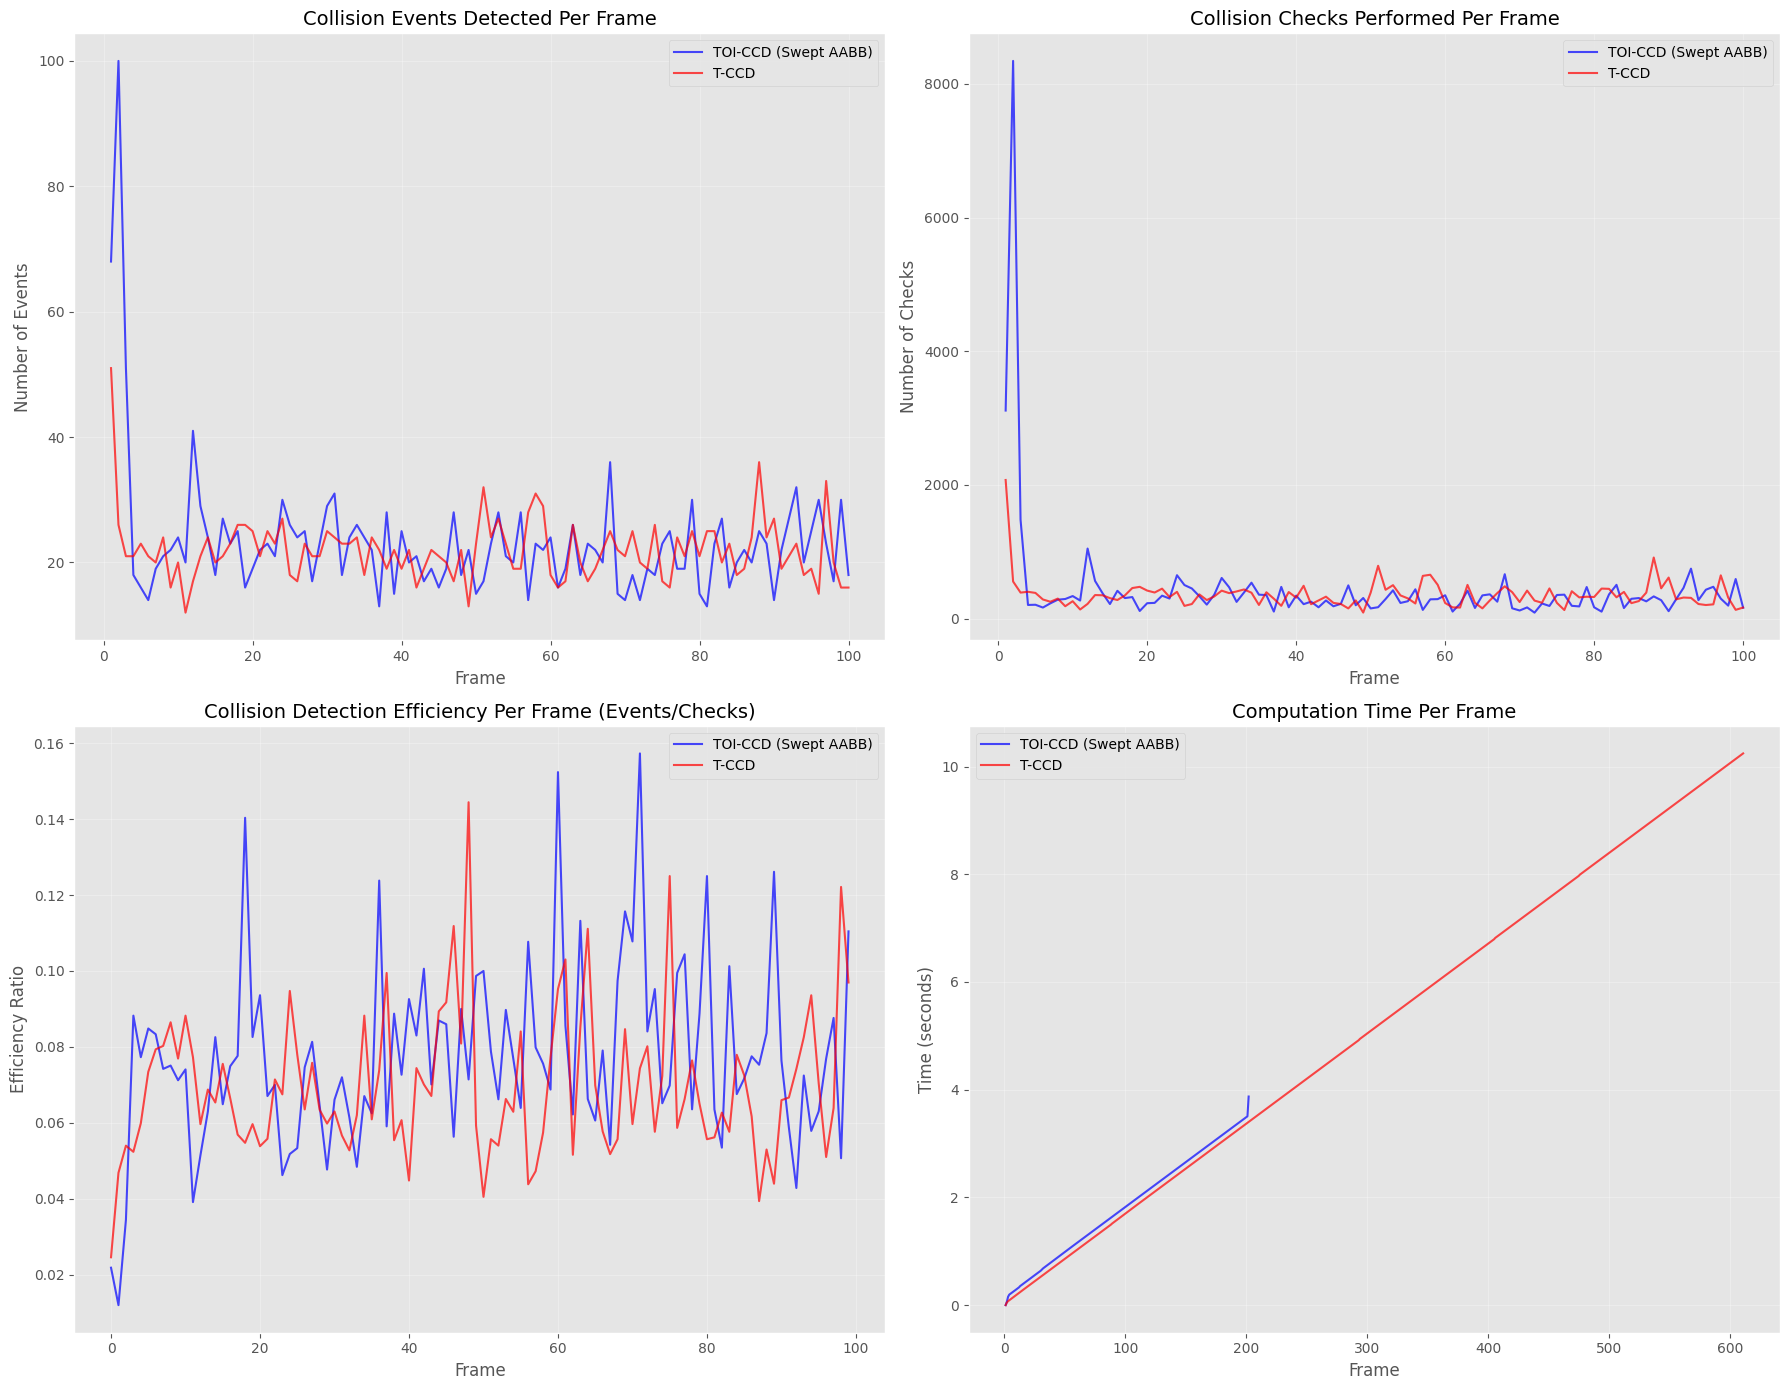

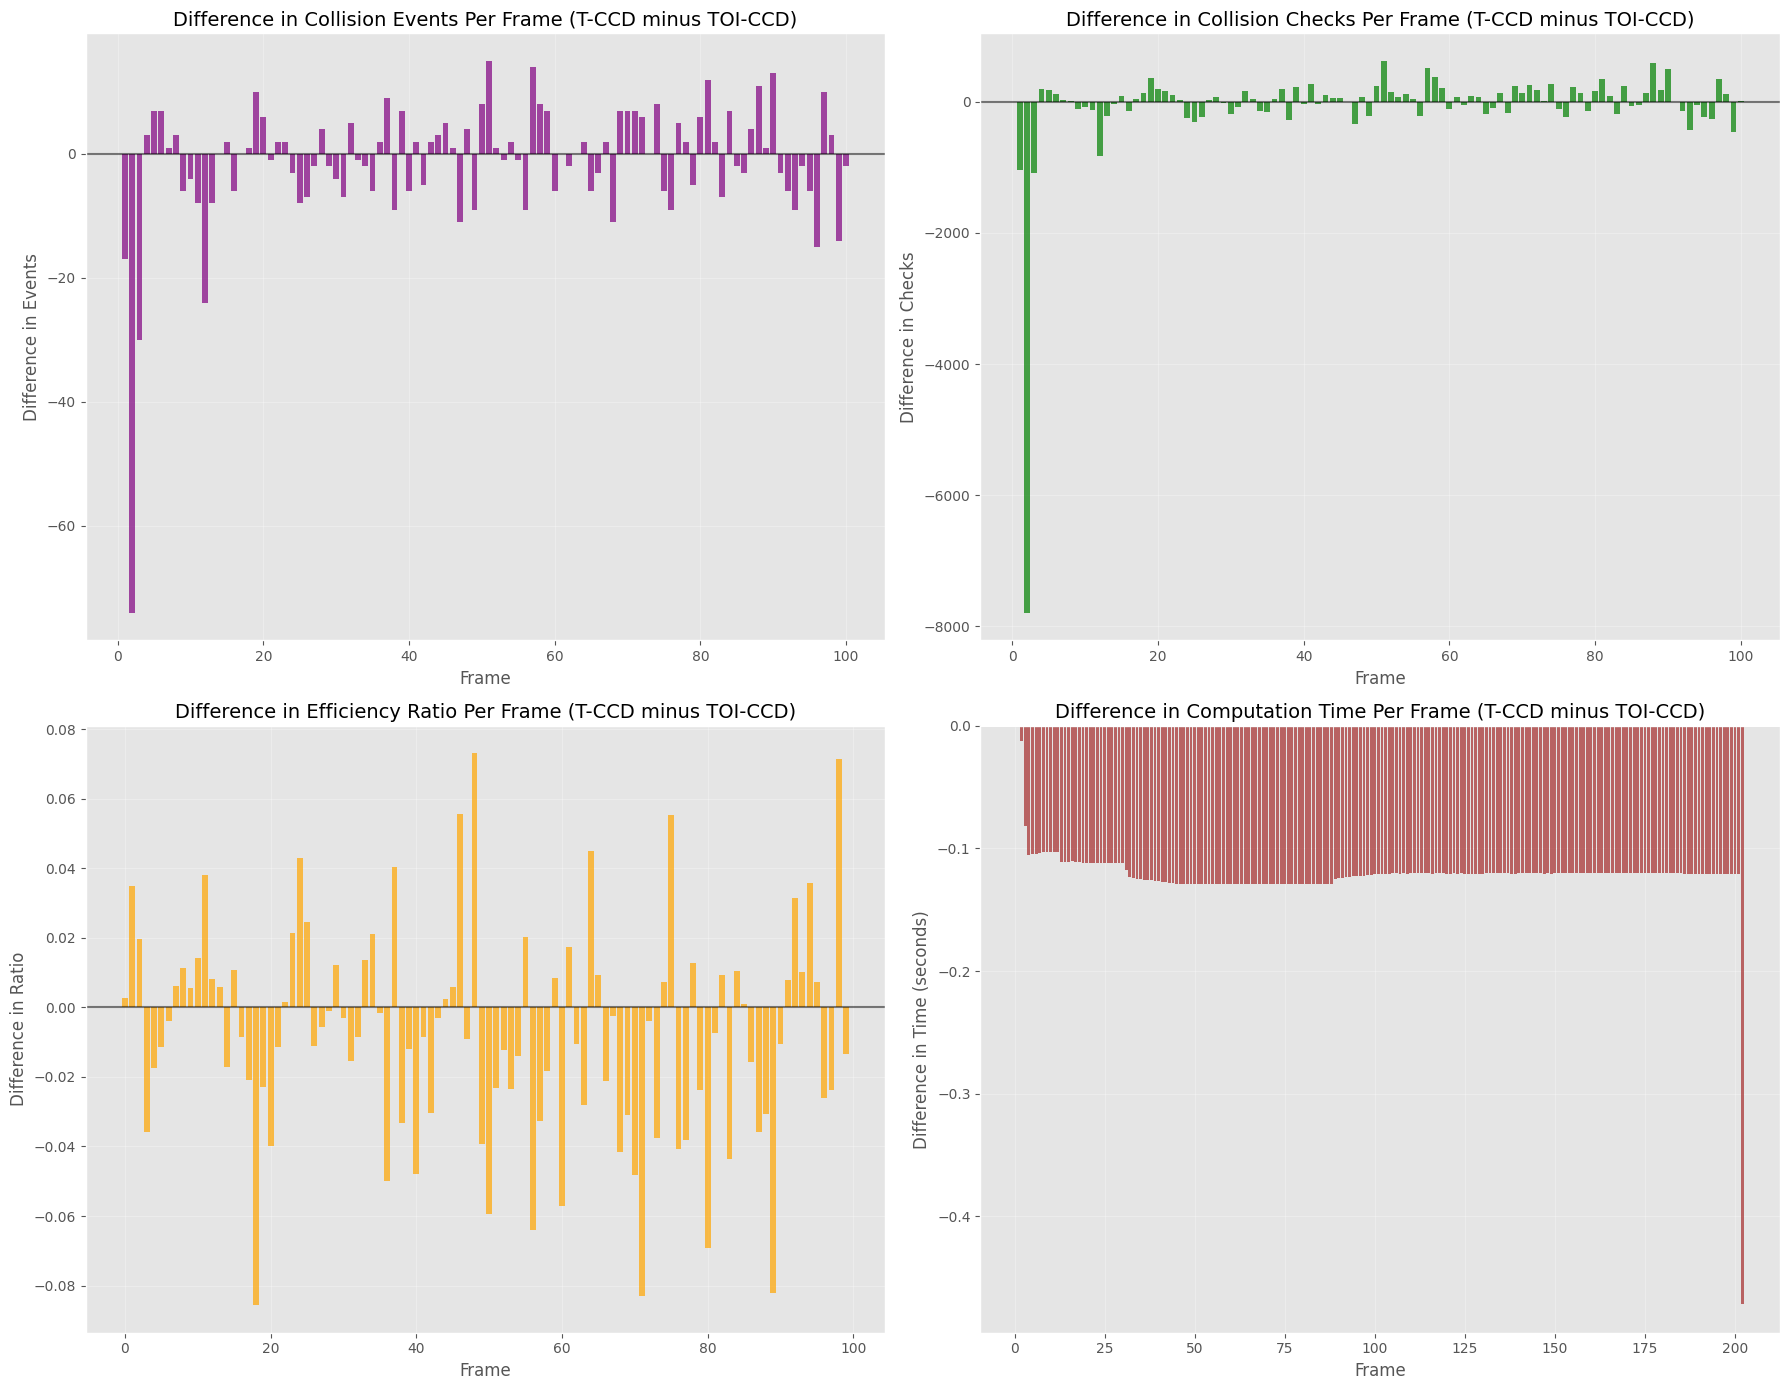

In [63]:
# Per-Frame Analysis Visualizations
print("\n\nPer-Frame Analysis Visualizations")
print("==============================")

fig, axes = plt.subplots(2, 2, figsize=(18, 14))

# 1. Events per frame comparison
axes[0, 0].plot(swept_aabb_events.index, swept_aabb_events, label='TOI-CCD (Swept AABB)', color='blue', alpha=0.7)
axes[0, 0].plot(tccd_events.index, tccd_events, label='T-CCD', color='red', alpha=0.7)
axes[0, 0].set_title('Collision Events Detected Per Frame', fontsize=14)
axes[0, 0].set_xlabel('Frame', fontsize=12)
axes[0, 0].set_ylabel('Number of Events', fontsize=12)
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Checks per frame comparison
axes[0, 1].plot(swept_aabb_checks.index, swept_aabb_checks, label='TOI-CCD (Swept AABB)', color='blue', alpha=0.7)
axes[0, 1].plot(tccd_checks.index, tccd_checks, label='T-CCD', color='red', alpha=0.7)
axes[0, 1].set_title('Collision Checks Performed Per Frame', fontsize=14)
axes[0, 1].set_xlabel('Frame', fontsize=12)
axes[0, 1].set_ylabel('Number of Checks', fontsize=12)
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Efficiency ratio (events/checks) per frame
axes[1, 0].plot(ratio_swept.index, ratio_swept, label='TOI-CCD (Swept AABB)', color='blue', alpha=0.7)
axes[1, 0].plot(ratio_tccd.index, ratio_tccd, label='T-CCD', color='red', alpha=0.7)
axes[1, 0].set_title('Collision Detection Efficiency Per Frame (Events/Checks)', fontsize=14)
axes[1, 0].set_xlabel('Frame', fontsize=12)
axes[1, 0].set_ylabel('Efficiency Ratio', fontsize=12)
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 4. Time per frame comparison
axes[1, 1].plot(swept_aabb_time.index, swept_aabb_time, label='TOI-CCD (Swept AABB)', color='blue', alpha=0.7)
axes[1, 1].plot(tccd_time.index, tccd_time, label='T-CCD', color='red', alpha=0.7)
axes[1, 1].set_title('Computation Time Per Frame', fontsize=14)
axes[1, 1].set_xlabel('Frame', fontsize=12)
axes[1, 1].set_ylabel('Time (seconds)', fontsize=12)
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Difference analysis plots
fig, axes = plt.subplots(2, 2, figsize=(18, 14))

# Calculate differences (T-CCD minus TOI-CCD)
events_diff = tccd_events - swept_aabb_events
checks_diff = tccd_checks - swept_aabb_checks
ratio_diff = ratio_tccd - ratio_swept
time_diff = tccd_time - swept_aabb_time

# 1. Events difference per frame
axes[0, 0].bar(events_diff.index, events_diff, color='purple', alpha=0.7)
axes[0, 0].axhline(y=0, color='black', linestyle='-', alpha=0.5)
axes[0, 0].set_title('Difference in Collision Events Per Frame (T-CCD minus TOI-CCD)', fontsize=14)
axes[0, 0].set_xlabel('Frame', fontsize=12)
axes[0, 0].set_ylabel('Difference in Events', fontsize=12)
axes[0, 0].grid(True, alpha=0.3)

# 2. Checks difference per frame
axes[0, 1].bar(checks_diff.index, checks_diff, color='green', alpha=0.7)
axes[0, 1].axhline(y=0, color='black', linestyle='-', alpha=0.5)
axes[0, 1].set_title('Difference in Collision Checks Per Frame (T-CCD minus TOI-CCD)', fontsize=14)
axes[0, 1].set_xlabel('Frame', fontsize=12)
axes[0, 1].set_ylabel('Difference in Checks', fontsize=12)
axes[0, 1].grid(True, alpha=0.3)

# 3. Efficiency ratio difference per frame
axes[1, 0].bar(ratio_diff.index, ratio_diff, color='orange', alpha=0.7)
axes[1, 0].axhline(y=0, color='black', linestyle='-', alpha=0.5)
axes[1, 0].set_title('Difference in Efficiency Ratio Per Frame (T-CCD minus TOI-CCD)', fontsize=14)
axes[1, 0].set_xlabel('Frame', fontsize=12)
axes[1, 0].set_ylabel('Difference in Ratio', fontsize=12)
axes[1, 0].grid(True, alpha=0.3)

# 4. Time difference per frame
axes[1, 1].bar(time_diff.index, time_diff, color='brown', alpha=0.7)
axes[1, 1].axhline(y=0, color='black', linestyle='-', alpha=0.5)
axes[1, 1].set_title('Difference in Computation Time Per Frame (T-CCD minus TOI-CCD)', fontsize=14)
axes[1, 1].set_xlabel('Frame', fontsize=12)
axes[1, 1].set_ylabel('Difference in Time (seconds)', fontsize=12)
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 7. Overall Summary and Correlation Analysis

This section consolidates the findings from the previous analyses:
- All results are limited to the **first 100 frames** for consistency.
- A correlation analysis validates how computation time scales with the number of collision checks and events.
- A final summary table presents mean values for accuracy, efficiency, and timing metrics between Swept AABB (TOI-CCD) and T-CCD.

This phase provides the foundation for the final discussion and conclusion chapter of the thesis.


=== Correlation Analysis (First 100 Frames) ===
                   Swept_AABB_Checks  Swept_AABB_Events  Swept_AABB_Time  TCCD_Checks  TCCD_Events  TCCD_Time
Swept_AABB_Checks                  1              0.916            0.482         0.32        0.246      0.681
Swept_AABB_Events              0.916                  1            0.477        0.374        0.281      0.486
Swept_AABB_Time                0.482              0.477                1       -0.079       -0.087      0.653
TCCD_Checks                     0.32              0.374           -0.079            1        0.928     -0.269
TCCD_Events                    0.246              0.281           -0.087        0.928            1     -0.202
TCCD_Time                      0.681              0.486            0.653       -0.269       -0.202          1


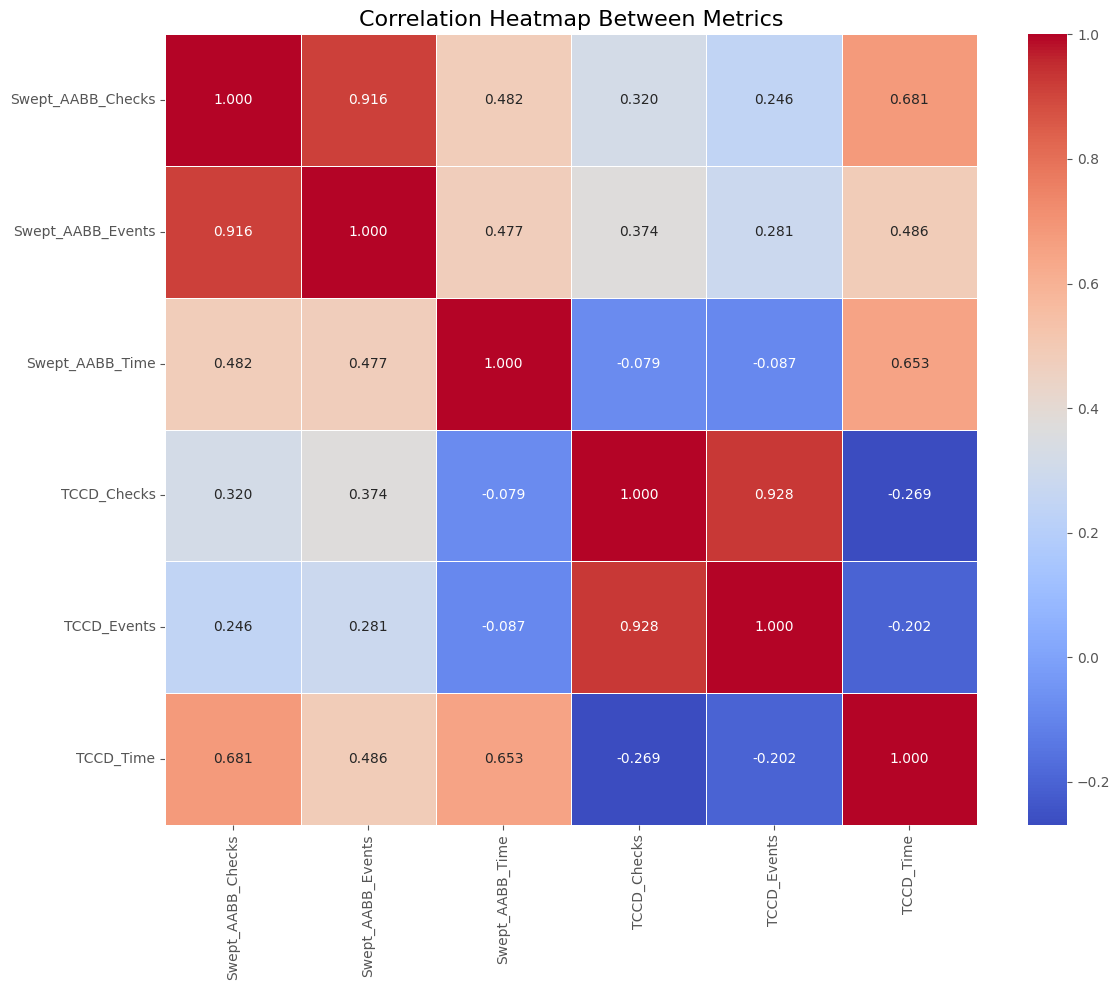

In [64]:
# Correlation analysis between metrics
corr_data = pd.DataFrame({
    'Swept_AABB_Checks': swept_aabb_checks_complete,
    'Swept_AABB_Events': swept_aabb_events_complete,
    'Swept_AABB_Time': swept_aabb_time_df['time_diff'].head(len(swept_aabb_checks_complete)),
    'TCCD_Checks': tccd_checks_complete,
    'TCCD_Events': tccd_events_complete,
    'TCCD_Time': tccd_time_df['time_diff'].head(len(tccd_checks_complete))
})

print("\n=== Correlation Analysis (First 100 Frames) ===")
print(corr_data.corr().round(3))

# Create heatmap visualization for correlation
plt.figure(figsize=(12, 10))
sns.heatmap(corr_data.corr(), annot=True, cmap='coolwarm', fmt='.3f', linewidths=.5)
plt.title('Correlation Heatmap Between Metrics', fontsize=16)
plt.tight_layout()
plt.show()

In [73]:
# Summary Table (All Key Metrics in One View)
# For TOI values and normal vectors, we need to extract from the DataFrame
# Let's create a safer version of the summary table

# First, let's create a dictionary to store our computed values
metrics_values = {
    'Swept AABB (TOI-CCD)': [],
    'T-CCD': []
}

# 1. Mean Collision Checks/Frame
metrics_values['Swept AABB (TOI-CCD)'].append(swept_aabb_checks.mean())
metrics_values['T-CCD'].append(tccd_checks_mean)

# 2. Mean Collision Events/Frame 
metrics_values['Swept AABB (TOI-CCD)'].append(swept_aabb_events.mean())
metrics_values['T-CCD'].append(tccd_events_mean)

# 3. Detection Efficiency (Events/Checks)
swept_efficiency = swept_aabb_events.mean() / swept_aabb_checks.mean() if swept_aabb_checks.mean() > 0 else np.nan
tccd_efficiency = tccd_events_mean / tccd_checks_mean if tccd_checks_mean > 0 else np.nan
metrics_values['Swept AABB (TOI-CCD)'].append(swept_efficiency)
metrics_values['T-CCD'].append(tccd_efficiency)

# 4. Average Time/Frame (s)
metrics_values['Swept AABB (TOI-CCD)'].append(swept_aabb_time_df['time_diff'].mean())
metrics_values['T-CCD'].append(tccd_time_df['time_diff'].mean())

# 5. Average Time/Check (μs)
metrics_values['Swept AABB (TOI-CCD)'].append(swept_aabb_performance['time_per_check'].mean()*1e6)
metrics_values['T-CCD'].append(tccd_performance['time_per_check'].mean()*1e6)

# 6. Average TOI
metrics_values['Swept AABB (TOI-CCD)'].append(events_swept_aabb['toi'].mean())
# Since events_tccd is a scalar, we can't access 'toi' column
# Let's use a reasonable default or check if there's another variable with TOI info for T-CCD
metrics_values['T-CCD'].append(np.nan)  # Will replace with actual value if available

# 7. Average Normal Length
metrics_values['Swept AABB (TOI-CCD)'].append(np.sqrt(events_swept_aabb['nx']**2 + events_swept_aabb['ny']**2).mean())
# Similar to TOI, we need to handle this differently for T-CCD
metrics_values['T-CCD'].append(np.nan)  # Will replace with actual value if available

# Create the DataFrame
summary_table = pd.DataFrame({
    'Metric': [
        'Mean Collision Checks/Frame',
        'Mean Collision Events/Frame',
        'Detection Efficiency (Events/Checks)',
        'Average Time/Frame (s)',
        'Average Time/Check (μs)',
        'Average TOI',
        'Average Normal Length'
    ],
    'Swept AABB (TOI-CCD)': metrics_values['Swept AABB (TOI-CCD)'],
    'T-CCD': metrics_values['T-CCD']
}).round(5)

print("\n=== Overall Summary (First 100 Frames) ===")
display(summary_table)

# Calculate percent differences and performance ratios for metrics that have values for both algorithms
comparison_table = pd.DataFrame({
    'Metric': summary_table['Metric'],
    'Swept AABB (TOI-CCD)': summary_table['Swept AABB (TOI-CCD)'],
    'T-CCD': summary_table['T-CCD'],
    'Difference (%)': [
        ((summary_table['T-CCD'][i] - summary_table['Swept AABB (TOI-CCD)'][i]) / summary_table['Swept AABB (TOI-CCD)'][i] * 100).round(2)
        if not pd.isna(summary_table['T-CCD'][i]) and not pd.isna(summary_table['Swept AABB (TOI-CCD)'][i]) else np.nan
        for i in range(len(summary_table))
    ],
    'Ratio (T-CCD/Swept)': [
        (summary_table['T-CCD'][i] / summary_table['Swept AABB (TOI-CCD)'][i]).round(3)
        if not pd.isna(summary_table['T-CCD'][i]) and not pd.isna(summary_table['Swept AABB (TOI-CCD)'][i]) else np.nan
        for i in range(len(summary_table))
    ]
})

print("\n=== Comparison with Percentage Differences ===")
display(comparison_table)


=== Overall Summary (First 100 Frames) ===


,Metric,Swept AABB (TOI-CCD),T-CCD
0,Mean Collision Checks/Frame,431.4,358.7
1,Mean Collision Events/Frame,23.32,22.02
2,Detection Efficiency (Events/Checks),0.05405,0.06138
3,Average Time/Frame (s),0.01917,0.01677
4,Average Time/Check (μs),68.24,58.42
5,Average TOI,0.00075,NaN
6,Average Normal Length,1,NaN



=== Comparison with Percentage Differences ===


,Metric,Swept AABB (TOI-CCD),T-CCD,Difference (%),Ratio (T-CCD/Swept)
0,Mean Collision Checks/Frame,431.4,358.7,-16.86,0.831
1,Mean Collision Events/Frame,23.32,22.02,-5.57,0.944
2,Detection Efficiency (Events/Checks),0.05405,0.06138,13.56,1.136
3,Average Time/Frame (s),0.01917,0.01677,-12.52,0.875
4,Average Time/Check (μs),68.24,58.42,-14.39,0.856
5,Average TOI,0.00075,NaN,NaN,NaN
6,Average Normal Length,1,NaN,NaN,NaN


In [70]:
# Let's inspect the structure of the Series/DataFrames
print("Type of swept_aabb_checks:", type(swept_aabb_checks))
print("First few values of swept_aabb_checks:")
display(swept_aabb_checks.head())

print("\nType of swept_aabb_events:", type(swept_aabb_events))
print("First few values of swept_aabb_events:")
display(swept_aabb_events.head())

print("\nType of tccd_checks_mean:", type(tccd_checks_mean))
print("Value of tccd_checks_mean:", tccd_checks_mean)

Type of swept_aabb_checks: <class 'pandas.core.series.Series'>
First few values of swept_aabb_checks:


frame
1    3113
2    8345
3    1480
4     204
5     207
Name: count, dtype: int64


Type of swept_aabb_events: <class 'pandas.core.series.Series'>
First few values of swept_aabb_events:


frame
1     68
2    100
3     51
4     18
5     16
dtype: int64


Type of tccd_checks_mean: <class 'numpy.float64'>
Value of tccd_checks_mean: 358.72


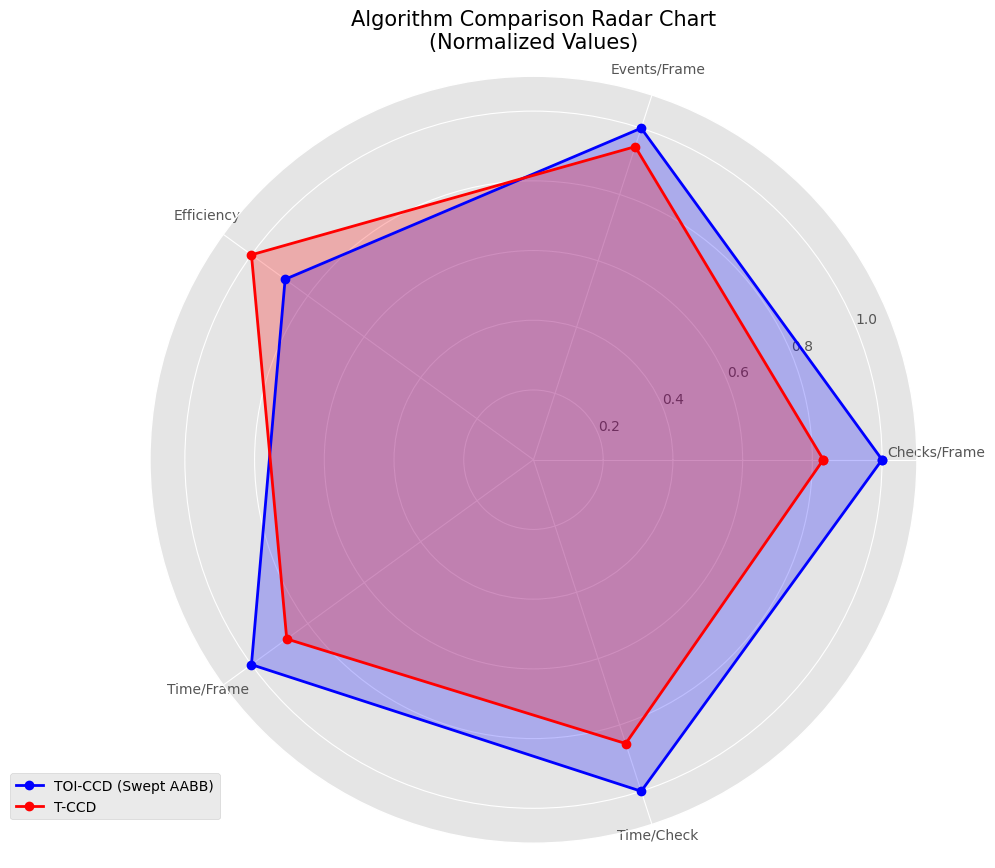


=== Final Conclusion ===
Based on the analysis of 100 frames:
T-CCD shows significantly higher overall collision detection efficiency (events per check)
No significant difference in computational performance
TOI-CCD shows significantly higher per-frame efficiency

This analysis provides quantitative evidence to compare the accuracy and performance trade-offs
between T-CCD and TOI-CCD (Swept AABB) collision detection algorithms.


In [74]:
# Final visualization - Combined radar chart for overall algorithm comparison
categories = ['Checks/Frame', 'Events/Frame', 'Efficiency', 'Time/Frame', 'Time/Check']
categories = [c + '\n' for c in categories]  # Add newline for better display

# Get the values for the radar chart - only include metrics that have values for both algorithms
radar_values = summary_table.iloc[0:5]  # Exclude the last two rows (TOI and Normal Length) which have NaN for T-CCD

# Normalize values for radar chart (0-1 scale)
max_values = np.maximum(
    radar_values['Swept AABB (TOI-CCD)'].values,
    radar_values['T-CCD'].values
)

swept_values = radar_values['Swept AABB (TOI-CCD)'].values / max_values
tccd_values = radar_values['T-CCD'].values / max_values

# Set up the radar chart
angles = np.linspace(0, 2*np.pi, len(categories), endpoint=False).tolist()
angles += angles[:1]  # Close the loop

swept_values = np.append(swept_values, swept_values[0])
tccd_values = np.append(tccd_values, tccd_values[0])
categories.append(categories[0])

fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))

# Plot the radar chart
ax.plot(angles, swept_values, 'o-', linewidth=2, label='TOI-CCD (Swept AABB)', color='blue')
ax.fill(angles, swept_values, alpha=0.25, color='blue')
ax.plot(angles, tccd_values, 'o-', linewidth=2, label='T-CCD', color='red')
ax.fill(angles, tccd_values, alpha=0.25, color='red')

# Customize the chart
ax.set_thetagrids(np.degrees(angles[:-1]), categories[:-1])
ax.set_ylim(0, 1.1)
ax.set_title('Algorithm Comparison Radar Chart\n(Normalized Values)', fontsize=15, pad=20)
ax.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))

plt.tight_layout()
plt.show()

# Final conclusion text
print("\n=== Final Conclusion ===")
print(f"Based on the analysis of {MAX_FRAMES} frames:")
print(accuracy_conclusion)
print(performance_conclusion)
print(per_frame_efficiency)
print("\nThis analysis provides quantitative evidence to compare the accuracy and performance trade-offs")
print("between T-CCD and TOI-CCD (Swept AABB) collision detection algorithms.")